In [1]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [2]:
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
import time
import pickle
import matplotlib.pyplot as plt
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize

from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


In [16]:
del(encoder)
del(decoder)
del(vae)

## Vanilla Contractive Autoencoder

In [8]:
latent_dim=64
input_shape= (18,18,736)
batch_size=32


x = Input(shape=(input_shape), name='input')

z = Flatten(name='flatten')(x)

z = Dense(latent_dim, activation='sigmoid', name='latent_layer')(z)

h_decoded = Dense(18*18*736, name='decoded_layer')(z)
h_decoded = Reshape((18,18,736))(h_decoded)

vae = Model(x, h_decoded, name='vae')

encoder = Model(x, z, name='encoder')

decoder_input = Input(shape=(input_shape))
_x_decoded_mean = Flatten(name='flatten')(decoder_input)
_x_decoded_mean = Dense(736, activation='sigmoid', name='decoded_layer')(_x_decoded_mean)

decoder = Model(decoder_input, _x_decoded_mean, name='decoder')

def contractive_loss(y_true, y_pred):
    lam = 1e-4
    xent_loss = K.mean(binary_crossentropy(y_true, y_pred))
    
    W = K.variable(value=vae.get_layer('latent_layer').get_weights()[0])
    W = K.transpose(W)
    
    h = vae.get_layer('latent_layer').output
    dh = h * (1-h)
    
    contractive = lam * K.sum((dh**2) * K.sum(W**2,axis=1), axis=1)
    
    return xent_loss + contractive

vae.compile(optimizer=Adam(), loss=contractive_loss)

print('encoder')
encoder.summary()
print('decoder')
decoder.summary()
print('vae')
vae.summary()


encoder
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18, 18, 736)       0         
_________________________________________________________________
flatten (Flatten)            (None, 238464)            0         
_________________________________________________________________
latent_layer (Dense)         (None, 64)                15261760  
Total params: 15,261,760
Trainable params: 15,261,760
Non-trainable params: 0
_________________________________________________________________
decoder
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
flatten (Flatten)            (None, 238464)            0         
______________

In [10]:
W = vae.get_layer('latent_layer').get_weights()[0]
W = W.T
W.shape

(64, 238464)

In [8]:
h = vae.get_layer('latent_layer').output
dh = h*(1-h)
h, dh

(<tf.Tensor 'latent_layer/Sigmoid:0' shape=(?, 64) dtype=float32>,
 <tf.Tensor 'mul:0' shape=(?, 64) dtype=float32>)

In [11]:
lam = 1e-4
contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)
contractive.shape

TensorShape([Dimension(None)])

In [10]:
K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

<tf.Tensor 'Sum_2:0' shape=(?, 18, 64) dtype=float32>

In [11]:
K.sum(W**2, axis=1)

<tf.Tensor 'Sum_3:0' shape=(64,) dtype=float32>

In [4]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/tf/data/Quan/datasets/webcam'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

label_dict = test_generator.class_indices

Found 444 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 239 images belonging to 31 classes.


In [5]:
with open('/tf/data/Quan/tf_models/amazon/extracted_features.hdf5', 'rb') as dt:
    s_labels, s_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/amazon/val_extracted_features.hdf5', 'rb') as dt:
    sval_labels, sval_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/extracted_features.hdf5', 'rb') as dt:
    t_labels, t_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/val_extracted_features.hdf5', 'rb') as dt:
    tval_labels, tval_features = pickle.load(dt)

with open('/tf/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    ttest_labels, ttest_features = pickle.load(dt)

# s_labels = [k.split('/')[-2] for k in s_labels]
# sval_labels = [k.split('/')[-2] for k in sval_labels]

t_labels = [k.split('/')[-2] for k in t_labels]
tval_labels = [k.split('/')[-2] for k in tval_labels]
    
# s_features.shape, sval_features.shape, t_features.shape

## Amazon

In [6]:
batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/amazon/vanilla_cae_p36_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(s_features, s_features, batch_size=batch_size, epochs=100, 
          validation_data=(sval_features, sval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/amazon/vanilla_cae_p36_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1576 samples, validate on 395 samples
Epoch 1/100
1576/1576 [==============================] - 2s 2ms/step - loss: 2.4694 - val_loss: 1.9759
Epoch 2/100
1576/1576 [==============================] - 2s 1ms/step - loss: 1.7487 - val_loss: 1.5525
Epoch 3/100
1576/1576 [==============================] - 2s 1ms/step - loss: 1.5256 - val_loss: 1.4355
Epoch 4/100
1576/1576 [==============================] - 2s 1ms/step - loss: 1.4622 - val_loss: 1.3853
Epoch 5/100
1576/1576 [==============================] - 3s 2ms/step - loss: 1.4339 - val_loss: 1.3638
Epoch 6/100
1576/1576 [==============================] - 2s 1ms/step - loss: 1.4325 - val_loss: 1.3643
Epoch 7/100
1576/1576 [==============================] - 2s 1ms/step - loss: 1.4312 - val_loss: 1.3607
Epoch 8/100
1576/1576 [==============================] - 2s 1ms/step - loss: 1.4392 - val_loss: 1.3637
Epoch 9/100
1576/1576 [===========

1576/1576 [==============================] - 2s 1ms/step - loss: 2.2023 - val_loss: 2.0696
Epoch 75/100
1576/1576 [==============================] - 2s 1ms/step - loss: 2.2134 - val_loss: 2.0843
Epoch 76/100
1576/1576 [==============================] - 2s 1ms/step - loss: 2.2364 - val_loss: 2.1108
Epoch 77/100
1576/1576 [==============================] - 2s 1ms/step - loss: 2.2484 - val_loss: 2.1156
Epoch 78/100
1576/1576 [==============================] - 2s 1ms/step - loss: 2.2572 - val_loss: 2.1233
Epoch 79/100
1576/1576 [==============================] - 2s 1ms/step - loss: 2.2648 - val_loss: 2.1344
Epoch 80/100
1576/1576 [==============================] - 2s 1ms/step - loss: 2.2790 - val_loss: 2.1458
Epoch 81/100
1576/1576 [==============================] - 2s 1ms/step - loss: 2.2858 - val_loss: 2.1517
Epoch 82/100
1576/1576 [==============================] - 2s 1ms/step - loss: 2.2932 - val_loss: 2.1601
Epoch 83/100
1576/1576 [==============================] - 2s 1ms/step - loss:

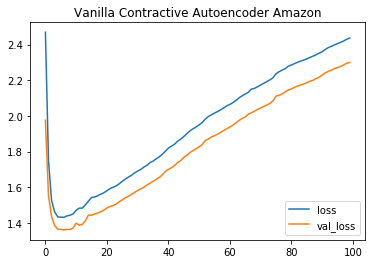

In [7]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Vanilla Contractive Autoencoder Amazon')
plt.show()

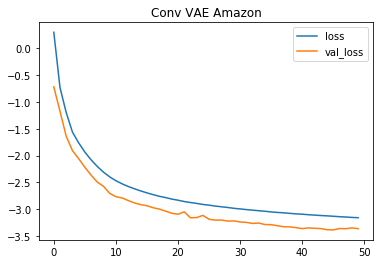

In [79]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Conv VAE Amazon')
plt.show()

## Webcam

In [10]:
batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam/vanilla_cae_p36_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(t_features, t_features, batch_size=batch_size, epochs=100, 
          validation_data=(tval_features, tval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/webcam/vanilla_cae_p36_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 1s 1ms/step - loss: 2.0515 - val_loss: 2.0061
Epoch 2/100
444/444 [==============================] - 1s 1ms/step - loss: 1.9924 - val_loss: 1.9687
Epoch 3/100
444/444 [==============================] - 1s 1ms/step - loss: 1.9652 - val_loss: 1.9458
Epoch 4/100
444/444 [==============================] - 1s 1ms/step - loss: 1.9513 - val_loss: 1.9321
Epoch 5/100
444/444 [==============================] - 1s 1ms/step - loss: 1.9431 - val_loss: 1.9221
Epoch 6/100
444/444 [==============================] - 1s 1ms/step - loss: 1.9373 - val_loss: 1.9156
Epoch 7/100
444/444 [==============================] - 1s 1ms/step - loss: 1.9331 - val_loss: 1.9098
Epoch 8/100
444/444 [==============================] - 1s 1ms/step - loss: 1.9305 - val_loss: 1.9073
Epoch 9/100
444/444 [==============================] - 1s 1ms/step - loss: 1.9281 - val_loss: 1.9036
Epoch 10/100
444/444 [=======================

Epoch 81/100
444/444 [==============================] - 1s 1ms/step - loss: 2.0663 - val_loss: 2.0181
Epoch 82/100
444/444 [==============================] - 1s 1ms/step - loss: 2.0690 - val_loss: 2.0213
Epoch 83/100
444/444 [==============================] - 1s 1ms/step - loss: 2.0744 - val_loss: 2.0215
Epoch 84/100
444/444 [==============================] - 1s 1ms/step - loss: 2.0778 - val_loss: 2.0286
Epoch 85/100
444/444 [==============================] - 1s 1ms/step - loss: 2.0825 - val_loss: 2.0325
Epoch 86/100
444/444 [==============================] - 1s 1ms/step - loss: 2.0968 - val_loss: 2.0487
Epoch 87/100
444/444 [==============================] - 1s 1ms/step - loss: 2.1040 - val_loss: 2.0451
Epoch 88/100
444/444 [==============================] - 1s 1ms/step - loss: 2.1020 - val_loss: 2.0437
Epoch 89/100
444/444 [==============================] - 1s 1ms/step - loss: 2.0992 - val_loss: 2.0449
Epoch 90/100
444/444 [==============================] - 1s 1ms/step - loss: 2.1010

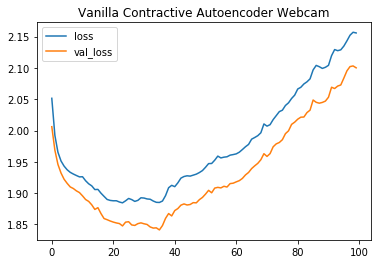

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Vanilla Contractive Autoencoder Webcam')
plt.show()

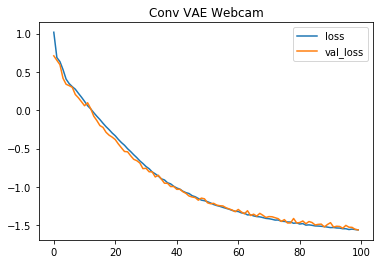

In [83]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Conv VAE Webcam')
plt.show()

## Combine Vanilla DAE

In [12]:
import keras.losses
keras.losses.contractive_loss = contractive_loss
input_shape = (18,18,736)

s_vae = load_model('/tf/data/Quan/tf_models/amazon/vanilla_cae_p36_model.hdf5')
t_vae = load_model('/tf/data/Quan/tf_models/webcam/vanilla_cae_p36_model.hdf5')

s_vae.summary()
t_vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18, 18, 736)       0         
_________________________________________________________________
flatten (Flatten)            (None, 238464)            0         
_________________________________________________________________
latent_layer (Dense)         (None, 64)                15261760  
_________________________________________________________________
decoded_layer (Dense)        (None, 238464)            15500160  
_________________________________________________________________
reshape_1 (Reshape)          (None, 18, 18, 736)       0         
Total params: 30,761,920
Trainable params: 30,761,920
Non-trainable params: 0
_________________________________________________________________
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Sh

In [13]:
import keras.losses
# keras.losses.vae_loss = vae_loss

# t encoder
t_encoder = Model(t_vae.inputs, t_vae.layers[2].output)

# s decoder
decoder_input = Input(shape=(64,))
h_decoded = Dense(18*18*736, activation='linear', name='decoded_layer')(decoder_input)
h_decoded = Reshape((18,18,736))(h_decoded)

s_decoder = Model(decoder_input, h_decoded, name='decoder')

for i in range(-2,0):
    s_decoder.layers[i].set_weights(s_vae.layers[i].get_weights())
    
print('t_encoder')
t_encoder.summary()

print('s_decoder')
s_decoder.summary()

t_encoder
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18, 18, 736)       0         
_________________________________________________________________
flatten (Flatten)            (None, 238464)            0         
_________________________________________________________________
latent_layer (Dense)         (None, 64)                15261760  
Total params: 15,261,760
Trainable params: 15,261,760
Non-trainable params: 0
_________________________________________________________________
s_decoder
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64)                0         
_________________________________________________________________
decoded_layer (Dense)        (None, 238464)            15500160  
__________

In [14]:
c_dae_outputs = s_decoder(t_encoder(t_encoder.inputs))
c_dae = Model(t_encoder.inputs, c_dae_outputs, name='combined_vae')
c_dae.summary()

Model: "combined_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18, 18, 736)       0         
_________________________________________________________________
model_1 (Model)              (None, 64)                15261760  
_________________________________________________________________
decoder (Model)              (None, 18, 18, 736)       15500160  
Total params: 30,761,920
Trainable params: 30,761,920
Non-trainable params: 0
_________________________________________________________________


In [15]:
t_num_labels = [label_dict[k] for k in t_labels]
tval_num_labels = [label_dict[k] for k in tval_labels]
ttest_num_labels = [label_dict[k] for k in ttest_labels]

t_num_labels = keras.utils.to_categorical(t_num_labels, 31)
tval_num_labels = keras.utils.to_categorical(tval_num_labels, 31)
ttest_num_labels = keras.utils.to_categorical(ttest_num_labels, 31)

transform_features = c_dae.predict(t_features, verbose=1)
val_transform_features = c_dae.predict(tval_features, verbose=1)
test_transform_features = c_dae.predict(ttest_features, verbose=1)

239/239 [==============================] - 0s 770us/step


In [17]:
# retrain source classifier

# Get source classififer (amazon)
s_baseline = load_model('/tf/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-3,-1):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
s_topmodel.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
___________________________________________________________________________________________

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 736)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 31)                22847     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31)                124       
_________________________________________________________________
activation_1 (Activation)    (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
______________________________________________________

In [26]:
s_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 1s 2ms/step


[3.80465843487983, 0.02092050209205021]

In [18]:
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam/amazon_cae_p36_classifier_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=200,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_cae_p36_classifier_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/200
444/444 [==============================] - 1s 1ms/step - loss: 4.9139 - accuracy: 0.0428 - val_loss: 3.6231 - val_accuracy: 0.0536
Epoch 2/200
444/444 [==============================] - 0s 419us/step - loss: 4.8639 - accuracy: 0.0270 - val_loss: 3.6168 - val_accuracy: 0.0536
Epoch 3/200
444/444 [==============================] - 0s 468us/step - loss: 5.1508 - accuracy: 0.0225 - val_loss: 3.6130 - val_accuracy: 0.0536
Epoch 4/200
444/444 [==============================] - 0s 583us/step - loss: 4.9614 - accuracy: 0.0473 - val_loss: 3.6138 - val_accuracy: 0.0536
Epoch 5/200
444/444 [==============================] - 0s 561us/step - loss: 4.8484 - accuracy: 0.0293 - val_loss: 3.6234 - val_accuracy: 0.0536
Epoch 6/200
444/444 [==============================] - 0s 462us/step - loss: 4.8036 - accuracy: 0.0315 - val_loss: 3.6285 - val_accuracy: 0.0536
Epoch 7/200
444/444 [==============================] - 0s 584us/step - loss: 4.9298 - 

Epoch 57/200
444/444 [==============================] - 0s 582us/step - loss: 4.2952 - accuracy: 0.0608 - val_loss: 3.6470 - val_accuracy: 0.0625
Epoch 58/200
444/444 [==============================] - 0s 561us/step - loss: 4.2261 - accuracy: 0.0676 - val_loss: 3.6545 - val_accuracy: 0.0446
Epoch 59/200
444/444 [==============================] - 0s 559us/step - loss: 4.2710 - accuracy: 0.0473 - val_loss: 3.6552 - val_accuracy: 0.0446
Epoch 60/200
444/444 [==============================] - 0s 535us/step - loss: 4.1537 - accuracy: 0.0428 - val_loss: 3.6393 - val_accuracy: 0.0446
Epoch 61/200
444/444 [==============================] - 0s 567us/step - loss: 4.1519 - accuracy: 0.0608 - val_loss: 3.6298 - val_accuracy: 0.0446
Epoch 62/200
444/444 [==============================] - 0s 604us/step - loss: 4.3400 - accuracy: 0.0586 - val_loss: 3.6194 - val_accuracy: 0.0446
Epoch 63/200
444/444 [==============================] - 0s 571us/step - loss: 4.2054 - accuracy: 0.0428 - val_loss: 3.6066 -

444/444 [==============================] - 0s 586us/step - loss: 3.7809 - accuracy: 0.0721 - val_loss: 3.3679 - val_accuracy: 0.0625
Epoch 114/200
444/444 [==============================] - 0s 549us/step - loss: 3.8697 - accuracy: 0.0586 - val_loss: 3.3655 - val_accuracy: 0.0625
Epoch 115/200
444/444 [==============================] - 0s 648us/step - loss: 3.8000 - accuracy: 0.0653 - val_loss: 3.3754 - val_accuracy: 0.0625
Epoch 116/200
444/444 [==============================] - 0s 583us/step - loss: 3.7674 - accuracy: 0.0743 - val_loss: 3.3775 - val_accuracy: 0.0625
Epoch 117/200
444/444 [==============================] - 0s 410us/step - loss: 3.8847 - accuracy: 0.0721 - val_loss: 3.3790 - val_accuracy: 0.0625
Epoch 118/200
444/444 [==============================] - 0s 499us/step - loss: 3.9341 - accuracy: 0.0495 - val_loss: 3.3730 - val_accuracy: 0.0625
Epoch 119/200
444/444 [==============================] - 0s 586us/step - loss: 3.8247 - accuracy: 0.0788 - val_loss: 3.3635 - val_ac

Epoch 169/200
444/444 [==============================] - 0s 591us/step - loss: 3.5572 - accuracy: 0.0833 - val_loss: 3.2709 - val_accuracy: 0.1250
Epoch 170/200
444/444 [==============================] - 0s 562us/step - loss: 3.6041 - accuracy: 0.0698 - val_loss: 3.2708 - val_accuracy: 0.1071
Epoch 171/200
444/444 [==============================] - 0s 555us/step - loss: 3.5308 - accuracy: 0.0991 - val_loss: 3.2681 - val_accuracy: 0.1071
Epoch 172/200
444/444 [==============================] - 0s 417us/step - loss: 3.5555 - accuracy: 0.0721 - val_loss: 3.2670 - val_accuracy: 0.0893
Epoch 173/200
444/444 [==============================] - 0s 592us/step - loss: 3.6146 - accuracy: 0.0856 - val_loss: 3.2658 - val_accuracy: 0.1071
Epoch 174/200
444/444 [==============================] - 0s 509us/step - loss: 3.5154 - accuracy: 0.0833 - val_loss: 3.2603 - val_accuracy: 0.1071
Epoch 175/200
444/444 [==============================] - 0s 585us/step - loss: 3.5555 - accuracy: 0.0743 - val_loss: 3

FileNotFoundError: [Errno 2] No such file or directory: '/data/Quan/tf_models/webcam/amazon_cae_p36_classifier_history.hdf5'

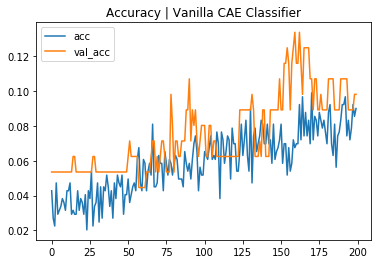

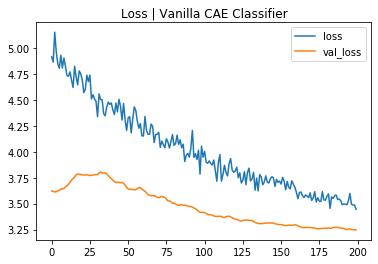

In [20]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy | Vanilla CAE Classifier')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss | Vanilla CAE Classifier')
plt.show()

In [22]:
test_topmodel = load_model('/tf/data/Quan/tf_models/webcam/amazon_cae_p36_classifier_model.hdf5')
test_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 0s 777us/step


[3.3765396632908775, 0.10460250824689865]

## Combine VAE

In [87]:
import keras.losses
keras.losses.vae_loss = vae_loss

s_vae = load_model('/data/Quan/tf_models/amazon/vae2_model.hdf5')
t_vae = load_model('/data/Quan/tf_models/webcam/vae2_model.hdf5')

s_vae.summary()
t_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
h (Dense)                       (None, 18, 18, 256)  188672      input[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________
lambda_sam

In [88]:
import keras.losses
keras.losses.vae_loss = vae_loss

# t encoder
t_encoder = Model(t_vae.inputs, t_vae.layers[4].output)

# s decoder
decoder_input = Input(shape=(18,18,64))
_h_decoded = Dense(256, activation='relu', name='decoder_h')(decoder_input)
_x_decoded_mean = Dense(736, activation='sigmoid', name='decoder_mean')(_h_decoded)

s_decoder = Model(decoder_input, _x_decoded_mean, name='decoder')

for i in range(-2,0):
    s_decoder.layers[i].set_weights(s_vae.layers[i].get_weights())
    
print('t_encoder')
t_encoder.summary()

print('s_decoder')
s_decoder.summary()

t_encoder
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
h (Dense)                       (None, 18, 18, 256)  188672      input[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________


In [89]:
c_vae_outputs = s_decoder(t_encoder(t_encoder.inputs))
c_vae = Model(t_encoder.inputs, c_vae_outputs, name='combined_vae')
c_vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18, 18, 736)       0         
_________________________________________________________________
model_11 (Model)             (None, 18, 18, 64)        221568    
_________________________________________________________________
decoder (Model)              (None, 18, 18, 736)       205792    
Total params: 427,360
Trainable params: 427,360
Non-trainable params: 0
_________________________________________________________________


In [90]:
t_num_labels = [label_dict[k] for k in t_labels]
tval_num_labels = [label_dict[k] for k in tval_labels]
ttest_num_labels = [label_dict[k] for k in ttest_labels]

t_num_labels = keras.utils.to_categorical(t_num_labels, 31)
tval_num_labels = keras.utils.to_categorical(tval_num_labels, 31)
ttest_num_labels = keras.utils.to_categorical(ttest_num_labels, 31)

transform_features = c_vae.predict(t_features, verbose=1)
val_transform_features = c_vae.predict(tval_features, verbose=1)
test_transform_features = c_vae.predict(ttest_features, verbose=1)

239/239 [==============================] - 0s 1ms/step


In [103]:
# retrain source classifier

# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-3,-1):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.05), metrics=['accuracy'])
s_topmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_10  (None, 736)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 736)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 31)                22847     
_________________________________________________________________
batch_normalization_10 (Batc (None, 31)                124       
_________________________________________________________________
activation_25 (Activation)   (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
_________________________________________________________________


In [17]:
s_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 1s 3ms/step


[3.8863200782233203, 0.02092050209205021]

In [104]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=300,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_classifier2_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/300
444/444 [==============================] - 6s 14ms/step - loss: 1.9063 - acc: 0.5405 - val_loss: 1.2786 - val_acc: 0.6429
Epoch 2/300
444/444 [==============================] - 0s 561us/step - loss: 0.9301 - acc: 0.7838 - val_loss: 0.9351 - val_acc: 0.7143
Epoch 3/300
444/444 [==============================] - 0s 557us/step - loss: 0.7312 - acc: 0.8288 - val_loss: 0.7812 - val_acc: 0.7768
Epoch 4/300
444/444 [==============================] - 0s 556us/step - loss: 0.5851 - acc: 0.8649 - val_loss: 0.7397 - val_acc: 0.8036
Epoch 5/300
444/444 [==============================] - 0s 555us/step - loss: 0.4781 - acc: 0.8851 - val_loss: 0.7184 - val_acc: 0.8125
Epoch 6/300
444/444 [==============================] - 0s 556us/step - loss: 0.4391 - acc: 0.8874 - val_loss: 0.6635 - val_acc: 0.7946
Epoch 7/300
444/444 [==============================] - 0s 556us/step - loss: 0.3895 - acc: 0.9032 - val_loss: 0.6499 - val_acc: 0.8036
Epoch 8/30

Epoch 61/300
444/444 [==============================] - 0s 558us/step - loss: 0.1766 - acc: 0.9527 - val_loss: 0.5233 - val_acc: 0.8750
Epoch 62/300
444/444 [==============================] - 0s 555us/step - loss: 0.1410 - acc: 0.9617 - val_loss: 0.4802 - val_acc: 0.8929
Epoch 63/300
444/444 [==============================] - 0s 552us/step - loss: 0.1280 - acc: 0.9707 - val_loss: 0.4864 - val_acc: 0.8750
Epoch 64/300
444/444 [==============================] - 0s 553us/step - loss: 0.1610 - acc: 0.9505 - val_loss: 0.5055 - val_acc: 0.8661
Epoch 65/300
444/444 [==============================] - 0s 553us/step - loss: 0.1777 - acc: 0.9302 - val_loss: 0.5272 - val_acc: 0.8482
Epoch 66/300
444/444 [==============================] - 0s 554us/step - loss: 0.1342 - acc: 0.9617 - val_loss: 0.4998 - val_acc: 0.8571
Epoch 67/300
444/444 [==============================] - 0s 553us/step - loss: 0.1025 - acc: 0.9775 - val_loss: 0.4715 - val_acc: 0.8750
Epoch 68/300
444/444 [==========================

444/444 [==============================] - 0s 553us/step - loss: 0.1098 - acc: 0.9640 - val_loss: 0.5319 - val_acc: 0.8750
Epoch 122/300
444/444 [==============================] - 0s 567us/step - loss: 0.0673 - acc: 0.9842 - val_loss: 0.5402 - val_acc: 0.8661
Epoch 123/300
444/444 [==============================] - 0s 562us/step - loss: 0.0733 - acc: 0.9775 - val_loss: 0.5856 - val_acc: 0.8661
Epoch 124/300
444/444 [==============================] - 0s 558us/step - loss: 0.1355 - acc: 0.9459 - val_loss: 0.5853 - val_acc: 0.8750
Epoch 125/300
444/444 [==============================] - 0s 558us/step - loss: 0.1083 - acc: 0.9685 - val_loss: 0.5622 - val_acc: 0.8750
Epoch 126/300
444/444 [==============================] - 0s 553us/step - loss: 0.1552 - acc: 0.9595 - val_loss: 0.5196 - val_acc: 0.8839
Epoch 127/300
444/444 [==============================] - 0s 555us/step - loss: 0.0894 - acc: 0.9730 - val_loss: 0.5106 - val_acc: 0.8750
Epoch 128/300
444/444 [==============================] 

Epoch 181/300
444/444 [==============================] - 0s 551us/step - loss: 0.0736 - acc: 0.9797 - val_loss: 0.5052 - val_acc: 0.8661
Epoch 182/300
444/444 [==============================] - 0s 555us/step - loss: 0.1164 - acc: 0.9707 - val_loss: 0.5247 - val_acc: 0.8661
Epoch 183/300
444/444 [==============================] - 0s 553us/step - loss: 0.0664 - acc: 0.9775 - val_loss: 0.5173 - val_acc: 0.8661
Epoch 184/300
444/444 [==============================] - 0s 557us/step - loss: 0.1249 - acc: 0.9685 - val_loss: 0.5426 - val_acc: 0.8661
Epoch 185/300
444/444 [==============================] - 0s 557us/step - loss: 0.1276 - acc: 0.9685 - val_loss: 0.5734 - val_acc: 0.8482
Epoch 186/300
444/444 [==============================] - 0s 556us/step - loss: 0.1024 - acc: 0.9775 - val_loss: 0.5936 - val_acc: 0.8661
Epoch 187/300
444/444 [==============================] - 0s 555us/step - loss: 0.0869 - acc: 0.9707 - val_loss: 0.5482 - val_acc: 0.8750
Epoch 188/300
444/444 [==================

Epoch 241/300
444/444 [==============================] - 0s 557us/step - loss: 0.0879 - acc: 0.9730 - val_loss: 0.5125 - val_acc: 0.8661
Epoch 242/300
444/444 [==============================] - 0s 556us/step - loss: 0.0840 - acc: 0.9797 - val_loss: 0.5405 - val_acc: 0.8661
Epoch 243/300
444/444 [==============================] - 0s 552us/step - loss: 0.0802 - acc: 0.9730 - val_loss: 0.5258 - val_acc: 0.8750
Epoch 244/300
444/444 [==============================] - 0s 552us/step - loss: 0.0616 - acc: 0.9797 - val_loss: 0.5037 - val_acc: 0.8750
Epoch 245/300
444/444 [==============================] - 0s 551us/step - loss: 0.0778 - acc: 0.9820 - val_loss: 0.5170 - val_acc: 0.8750
Epoch 246/300
444/444 [==============================] - 0s 552us/step - loss: 0.0807 - acc: 0.9662 - val_loss: 0.4712 - val_acc: 0.8839
Epoch 247/300
444/444 [==============================] - 0s 559us/step - loss: 0.0759 - acc: 0.9775 - val_loss: 0.4731 - val_acc: 0.8750
Epoch 248/300
444/444 [==================

exe time:  84.73720645904541


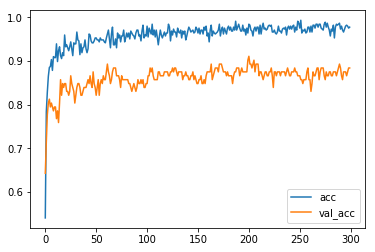

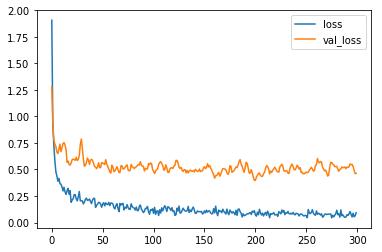

In [107]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [109]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5')
test_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 2s 10ms/step


[0.7559444258402581, 0.8368200844301839]

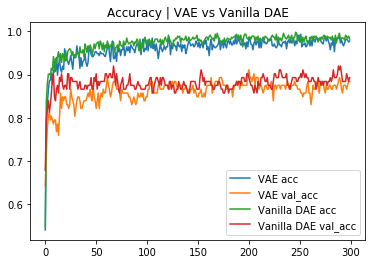

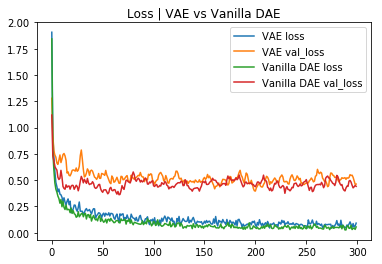

In [26]:
with open('/data/Quan/tf_models/webcam/amazon_classifier2_history.hdf5', 'rb') as dt:
    vae_history = pickle.load(dt)
    
%matplotlib inline
plt.plot(vae_history.history['acc'], label='VAE acc')
plt.plot(vae_history.history['val_acc'], label='VAE val_acc')
plt.plot(history.history['acc'], label='Vanilla DAE acc')
plt.plot(history.history['val_acc'], label='Vanilla DAE val_acc')
plt.legend()
plt.title('Accuracy | VAE vs Vanilla DAE')
plt.show()

plt.plot(vae_history.history['loss'], label='VAE loss')
plt.plot(vae_history.history['val_loss'], label='VAE val_loss')
plt.plot(history.history['loss'], label='Vanilla DAE loss')
plt.plot(history.history['val_loss'], label='Vanilla DAE val_loss')
plt.legend()
plt.title('Loss | VAE vs Vanilla DAE')
plt.show()